In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

import torch
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from CapsuleNet import CapsuleNetwork, CapsuleLoss, display_images
from utils import DICOMCoarseDataset, display_data_loader_batch

In [2]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 50
image_size = 80 #best yet 80 with 87%
classes = ["nodule", "non-nodule"]
train_ratio = 0.8

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

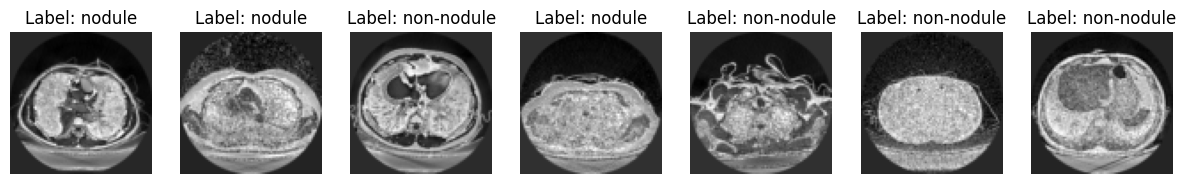

In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),          # Random rotation up to 15 degrees
    transforms.RandomHorizontalFlip(),              # Random horizontal flip
    transforms.RandomVerticalFlip(),                # Random vertical flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transform
])

dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=["nodule", "non-nodule"], transform=transform)
dataset.visualize_images(num_images=7)

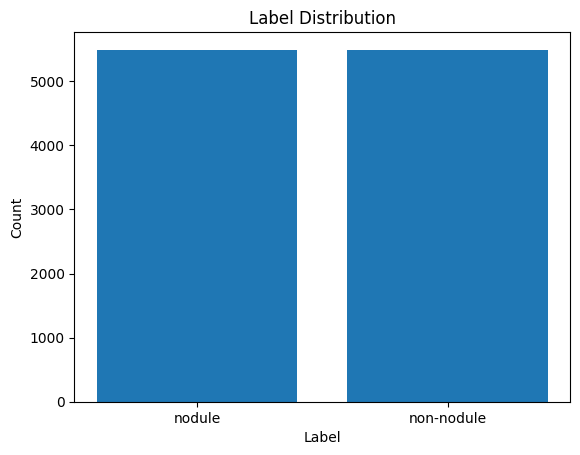

In [4]:
dataset.display_label_distribution()

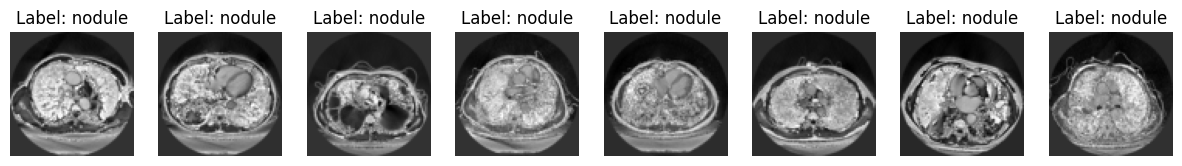

In [5]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# train_dataset.dataset.transform = train_transforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

display_data_loader_batch(train_loader, classes)

In [6]:
TRAIN_ON_GPU = torch.cuda.is_available()
capsule_net = CapsuleNetwork(image_size=image_size, num_classes=len(classes), train_on_gpu=TRAIN_ON_GPU)
print(capsule_net)

if TRAIN_ON_GPU:
    capsule_net = capsule_net.cuda()

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=6400, bias=True)
      (5): Sigmoid()
    )
  )
)


In [7]:
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

In [8]:
n_epochs = 5
losses = capsule_net.train_model(train_loader, criterion, optimizer, n_epochs, print_every=1)

Epoch: 1 	Training Loss: 7.11755586
Epoch: 1 	Training Loss: 3.44815493
Epoch: 1 	Training Loss: 3.43496704
Epoch: 1 	Training Loss: 3.22735333
Epoch: 1 	Training Loss: 3.21538830
Epoch: 1 	Training Loss: 3.06034851
Epoch: 1 	Training Loss: 2.90687442
Epoch: 1 	Training Loss: 2.80039239
Epoch: 1 	Training Loss: 2.54430866
Epoch: 1 	Training Loss: 2.43586302
Epoch: 1 	Training Loss: 2.28926444
Epoch: 1 	Training Loss: 2.15741110
Epoch: 1 	Training Loss: 1.97237968
Epoch: 1 	Training Loss: 1.90284240
Epoch: 1 	Training Loss: 1.75848413
Epoch: 1 	Training Loss: 1.70464718
Epoch: 1 	Training Loss: 1.64005733
Epoch: 1 	Training Loss: 1.61948347
Epoch: 1 	Training Loss: 1.63370645
Epoch: 1 	Training Loss: 1.57378924
Epoch: 1 	Training Loss: 1.52377045
Epoch: 1 	Training Loss: 1.52017999
Epoch: 1 	Training Loss: 1.54646325
Epoch: 1 	Training Loss: 1.54057860
Epoch: 1 	Training Loss: 1.50591302
Epoch: 1 	Training Loss: 1.55041778
Epoch: 1 	Training Loss: 1.52930176
Epoch: 1 	Training Loss: 1.4

Test Loss: 1.06441346

Test Accuracy of     0: 91% (1030/1125)
Test Accuracy of     1: 81% (879/1073)

Test Accuracy (Overall): 86% (1909/2198)


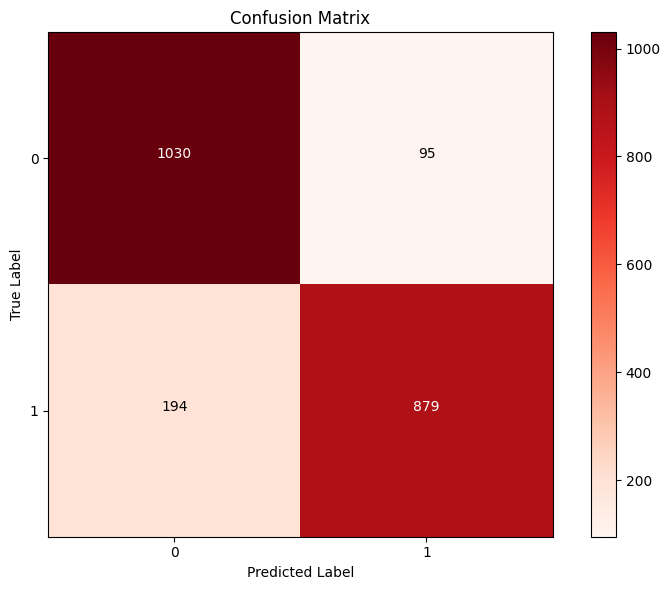

In [9]:
caps_outputs, images, reconstructions = capsule_net.test_model(criterion, test_loader)

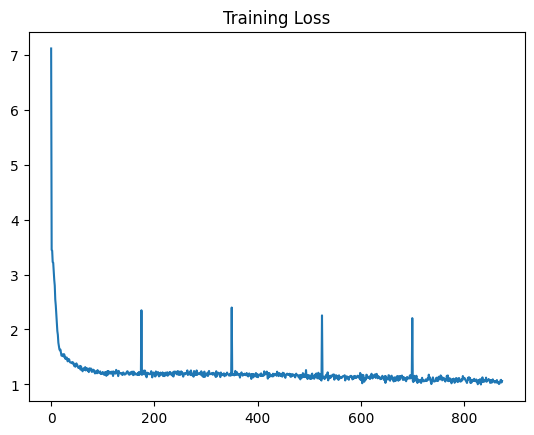

In [10]:
plt.plot(losses)
plt.title("Training Loss")
plt.show()

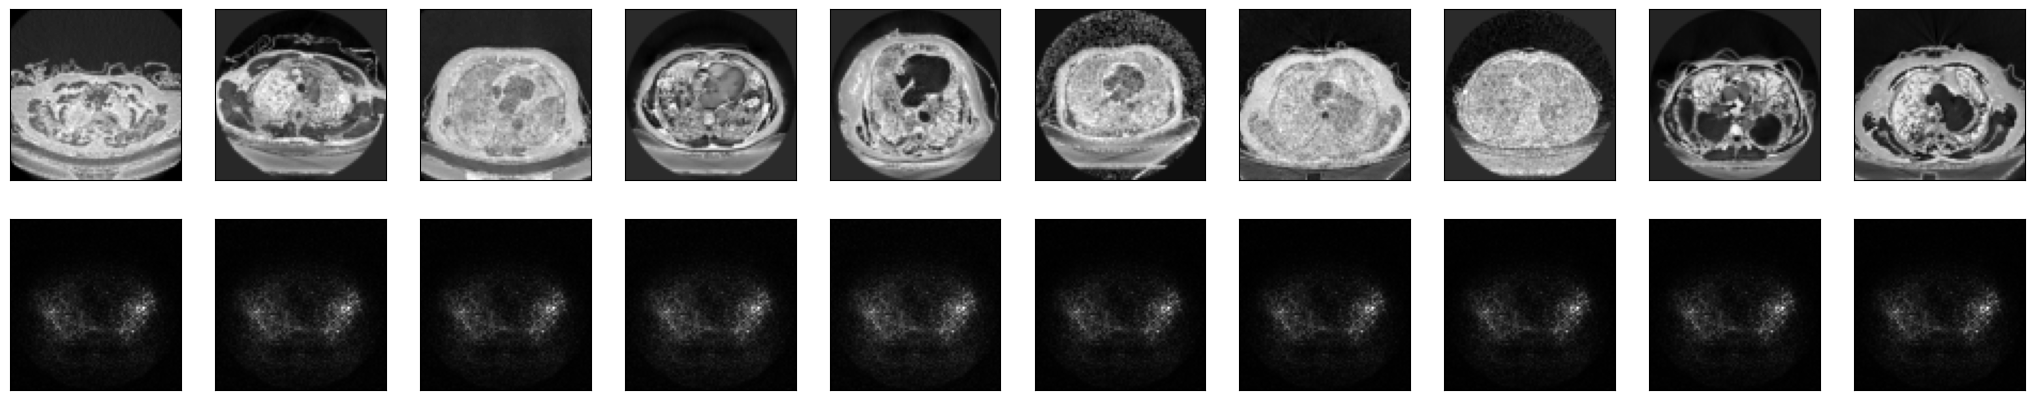

In [12]:
display_images(images, reconstructions)